In [1]:
import pandas as pd
from basketball_reference_web_scraper import client
from basketball_reference_web_scraper.data import OutputType

## Gathering NBA Player Data

In [2]:
YEARS = [2020, 2019, 2018, 2017, 2016, 2015]
nba_player_stats_df = pd.DataFrame()
for year in YEARS:
    all_player_season_total = client.players_season_totals(season_end_year=year, output_type=OutputType.JSON)
    nba_player_stats_year_df = pd.read_json(all_player_season_total)
    nba_player_stats_df = pd.concat([nba_player_stats_df, nba_player_stats_year_df])
nba_player_stats_df = nba_player_stats_df.drop_duplicates(subset=['slug'])
nba_player_stats_df = nba_player_stats_df.reset_index().drop('index',axis=1)

Making sure duplicated data is removed

In [3]:
nba_player_stats_df['slug'].value_counts()

edwarvi01    1
turnemy01    1
hudsole01    1
hamilju01    1
brownja01    1
            ..
browntr01    1
abrinal01    1
villach01    1
blackta01    1
mclaujo01    1
Name: slug, Length: 1019, dtype: int64

## Filtering out Players who do not Fit Requirements
* The requirements include having attempted a mininmum of 750 career three point attempts and having college data accessible 
* 750 was decided as the threshold from reading this article https://fansided.com/2015/01/30/freelance-friday-small-sample-size-stop-small/

In [168]:
from sportsreference.nba.roster import Player as NBAPlayer
from sportsreference.ncaab.roster import Player as NCAAPlayer

nba_player_names = nba_player_stats_df[['name', 'slug']]
nba_college_player_df_column_names = ['name','slug','NBA_3PA', 'NBA_3P%', 'NCAA_FT%', 'NCAA_3P%']
nba_ncaa_raw_player_data = []
nba_player_college_data_not_found = []

for player_index in range(len(nba_player_names)):
    nba_player_name = nba_player_names['name'].loc[player_index]
    nba_player_id = nba_player_names['slug'].loc[player_index]
    nba_player = NBAPlayer(nba_player_id)
    if (nba_player.three_point_attempts > 750):
        try: 
            if "." in nba_player_name:
                nba_player_name = nba_player_name.split('.')
                nba_player_name = "".join(nba_player_name)
            ncaa_player_id = nba_player_name.lower().split()
            ncaa_player_id = '-'.join(ncaa_player_id) + '-1'
            ncaa_player = NCAAPlayer(ncaa_player_id) 
            
            #Each index matches the nba_college_player_df_column_names
            nba_ncaa_raw_player_data.append([
                nba_player_name,
                nba_player_id, 
                nba_player.three_point_attempts,
                nba_player.three_point_percentage,
                ncaa_player.free_throw_percentage,
                ncaa_player.three_point_percentage,

            ])
            
        except TypeError as e:
            print(nba_player_names['name'].loc[player_index], ' not found! ', ncaa_player_id)
            nba_player_college_data_not_found.append([
                nba_player_names['name'].loc[player_index],
                nba_player_id, 
                player_index
            ])

Giannis Antetokounmpo  not found!  giannis-antetokounmpo-1
J.J. Barea  not found!  jj-barea-1
Nicolas Batum  not found!  nicolas-batum-1
Marco Belinelli  not found!  marco-belinelli-1
Dāvis Bertāns  not found!  dāvis-bertāns-1
Nemanja Bjelica  not found!  nemanja-bjelica-1
Bogdan Bogdanović  not found!  bogdan-bogdanović-1
Bojan Bogdanović  not found!  bojan-bogdanović-1
Luka Dončić  not found!  luka-dončić-1
Goran Dragić  not found!  goran-dragić-1
Yogi Ferrell  not found!  yogi-ferrell-1
Evan Fournier  not found!  evan-fournier-1
Danilo Gallinari  not found!  danilo-gallinari-1
Marc Gasol  not found!  marc-gasol-1
Mario Hezonja  not found!  mario-hezonja-1
Serge Ibaka  not found!  serge-ibaka-1
Ersan İlyasova  not found!  ersan-i̇lyasova-1
Joe Ingles  not found!  joe-ingles-1
LeBron James  not found!  lebron-james-1
Nikola Jokić  not found!  nikola-jokić-1
C.J. Miles  not found!  cj-miles-1
Patty Mills  not found!  patty-mills-1
E'Twaun Moore  not found!  e'twaun-moore-1
Emmanuel Mud

In [172]:
nba_ncaa_data_df = pd.DataFrame(nba_ncaa_raw_player_data, columns =nba_college_player_df_column_names)
nba_ncaa_not_found_df = pd.DataFrame(nba_player_college_data_not_found, columns=['name','slug', 'player_df_index'])

In [182]:
nba_ncaa_data_df['NBA_3P%'].corr(nba_ncaa_data_df['NCAA_FT%'])

0.27978178230451334

In [183]:
nba_ncaa_data_df.corr()

,NBA_3PA,NBA_3P%,NCAA_FT%,NCAA_3P%
NBA_3PA,1.000000,0.312761,0.107970,0.048057
NBA_3P%,0.312761,1.000000,0.279782,0.206285
NCAA_FT%,0.107970,0.279782,1.000000,0.407608
NCAA_3P%,0.048057,0.206285,0.407608,1.000000


<AxesSubplot:xlabel='NCAA_FT%', ylabel='NBA_3P%'>

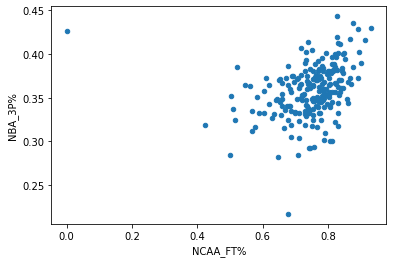

In [178]:
import matplotlib as plt
nba_ncaa_data_df.plot.scatter(x="NCAA_FT%", y="NBA_3P%")

In [199]:
nba_ncaa_data_df.sort_values(by=['NCAA_FT%'], ascending=False)[:10]

,name,slug,NBA_3PA,NBA_3P%,NCAA_FT%,NCAA_3P%
190,Steve Novak,novakst01,1337,0.430,0.931,0.461
113,JJ Redick,redicjj01,4526,0.416,0.912,0.406
71,Kyrie Irving,irvinky01,2870,0.390,0.901,0.462
164,Luke Babbitt,babbilu01,979,0.402,0.893,0.421
79,Kyle Korver,korveky01,5715,0.429,0.891,0.453
154,Jodie Meeks,meeksjo01,2078,0.373,0.890,0.386
33,Stephen Curry,curryst01,5739,0.435,0.876,0.412
16,Malcolm Brogdon,brogdma01,828,0.385,0.876,0.365
96,Ben McLemore,mclembe01,1695,0.366,0.870,0.420
87,Damian Lillard,lillada01,4764,0.373,0.867,0.390


In [201]:
nba_ncaa_data_df.to_csv('data/nba_ncaa_data_df_2015_2020.csv', index=False)
nba_ncaa_not_found_df.to_csv('data/nba_ncaa_not_found_df_2015_2020.csv', index=False)

In [82]:
from bs4 import BeautifulSoup
from selenium import webdriver

driver = webdriver.Chrome("C:/Users/Aman Riat/Downloads/chromedriver_win32/chromedriver.exe")
driver.get(url)
soup = BeautifulSoup(driver.page_source,'html.parser')

In [84]:
table = soup.find('table', id="all_college_stats")
table

<table class="sortable stats_table now_sortable" data-cols-to-freeze="1" id="all_college_stats"><caption>College Stats Table</caption>
<colgroup><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/></colgroup>
<thead>
<tr class="over_header">
<th aria-label="" class="over_header center" colspan="3" data-stat=""></th>
<th aria-label="" class="over_header center" colspan="2" data-stat="DUMMY"> </th>
<th aria-label="" class="over_header center" colspan="14" data-stat="totals">Totals</th>
<th aria-label="" class="over_header center" colspan="3" data-stat="header_shooting">Shooting</th>
<th aria-label="" class="over_header center" colspan="4" data-stat="header_per_g">Per Game</th>
</tr>
<tr>
<th aria-label="If listed as single number, the year the season ended.★ - Indicates All-Star for league.Only on regular season tables." class="poptip sort_default_asc center" data-stat="season" data-ti